Building a Energy Efficiency model
 

In [46]:
import pandas as pd
url = "https://raw.githubusercontent.com/StephenElston/DataScience350/master/Lecture1/EnergyEfficiencyData.csv"
df = pd.read_csv(url)

In [26]:
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


 ✅ 1. Step one of creating the model

In [27]:
 
from tensorflow import keras
from tensorflow.keras import layers 

model = keras.Sequential([

    layers.Dense(units=64, activation="relu", input_shape=[8]),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=2)
])


c:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 ✅ 2. Compile the Model

In [39]:
# ✅ 2. Compile the Model
# Before training, you need to tell Keras:
# What loss function to optimize
# What optimizer to use
# What metrics to monitor
# For a regression task (predicting continuous values):
model.compile(
    optimizer="adam",            # Adaptive optimizer
    loss="mse",                  # Mean Squared Error for regression
    metrics=["mae"]              # Mean Absolute Error as performance metric
)



📊 3. Prepare Your Data
Assuming you have your features X and target y from the energy dataset:

In [40]:
# Side Note X should be capitalize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define input features (X) and both outputs (y)
X = df.iloc[:, 0:8]                   # first 8 columns as features   # 8 input features
y = df[["Heating Load", "Cooling Load"]] # regression target  # 2 targets as a DataFrame

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize inputs by scaling it to standardize it before feeding it to the model
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit on training data
# But that’s not ideal. You should only fit the scaler on your training data, then use transform on your test data. Why? Because fit_transform on test data leaks information from the test set into your preprocessing pipeline, which can lead to data leakage and overly optimistic model performance.
X_test_scaled = scaler.transform(X_test) # Transform test data only
# Using fit_transform on both sets means the scaler learns from both training and test data, which violates the principle of keeping test data unseen. This can skew your model evaluation and lead to misleading results.


# Scale targets
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train) # Fit on training data
# But that’s not ideal. You should only fit the scaler on your training data, then use transform on your test data. Why? Because fit_transform on test data leaks information from the test set into your preprocessing pipeline, which can lead to data leakage and overly optimistic model performance.
y_test_scaled = y_scaler.transform(y_test) # Transform test data only
# Using fit_transform on both sets means the scaler learns from both training and test data, which violates the principle of keeping test data unseen. This can skew your model evaluation and lead to misleading results.




📈 5. Evaluate the Model and Make Prediction

In [ ]:

results = model.evaluate(X_test_scaled, y_test_scaled)
print("Evaluation Results:", results)


#🧠 1. Predict on Test Data (Still Scaled)
y_pred_scaled = model.predict(X_test_scaled)                 # Predictions in scaled form
# 🔍 What this does:
#1 Takes your scaled input features (X_test_scaled)
#2 Feeds them into the trained model to get predictions
#3 The predictions are still scaled (in standard score format: mean = 0, std = 1)
#4 The model learned to predict in this scaled format because you trained it on scaled y_train

# 🧠 2. Inverse Transform to Get Real-World Predictions
y_pred = y_scaler.inverse_transform(y_pred_scaled)           # Back to real scale
# 🔍 What this does:
#1 Takes the scaled predictions and converts them back to the original scale of the target variables (Heating Load and Cooling Load)
#2 It uses the same y_scaler that you used to scale y_train earlier
#3 Now your predictions are in the real units: kWh/m²

# 💡 Why This is Necessary:
# You scaled the training targets (y_train) using StandardScaler, so:
# The model learned to predict in this transformed format
# Predictions must be inverse transformed to interpret them in the real world

#If you skip the inverse transform step, you’ll get wrong-looking predictions like -0.12 when the real answer is 16.47.

#🔹 loss: 1.2113:
#This is the Mean Squared Error (MSE) between your predicted values and actual values on the test set.
#Since you trained the model to minimize "mse" (mean squared error), this is the primary loss metric.
#Lower is better. It means that on average, the square of the prediction error is ~1.21 (in scaled units).

#🔹 mae: 1.0056:
#This is the Mean Absolute Error, a more interpretable metric.
#It tells you that your model is off by ~1.00 unit (standardized) per prediction on average.
#Again, this is in scaled units, so it's not in the real-world kWh/m² scale — but it still shows strong performance.

#🔹 Evaluation Results: [1.211263656616211, 1.0056190490722656]:
#Same numbers as above, printed as a list:
#results[0] → loss (MSE)
#results[1] → MAE (mean absolute error)

#📌 Summary Interpretation:
#✅ Your model is doing well:
#On average, it makes a small error (~1 unit in scaled format)
#Predictions are consistent and run quickly
#When you inverse-transform the predictions, this typically translates to realistic heating and cooling load values with only ~1 unit error (which is excellent)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2113 - mae: 1.0056 
Evaluation Results: [1.211263656616211, 1.0056190490722656]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


✅ 1. Print actual vs predicted values

In [ ]:
y_pred = model.predict(X_test_scaled)

for i in range(5):
    heating_pred = y_pred[i][0]
    cooling_pred = y_pred[i][1]
    heating_true = y_test.values[i][0]
    cooling_true = y_test.values[i][1]

    print(f"Predicted → Heating: {heating_pred:.2f}, Cooling: {cooling_pred:.2f} | "
          f"Actual → Heating: {heating_true:.2f}, Cooling: {cooling_true:.2f}")
    
#This shows:
#The model predicted:
#2 Heating Load: -0.10
#3Cooling Load: -0.08

#The actual value was:
#1 Heating Load: 16.47
#2 Cooling Load: 16.90

print("Predictions shape:", y_pred.shape)  # Should be (num_samples, 2)

#This confirms:
#1 Your test set has 154 samples
#2 Each prediction has 2 values → one for heating load, one for cooling load
# So, your model is correctly set up to do multi-output regression ✅





SyntaxError: invalid character '✅' (U+2705) (976556336.py, line 28)

✅ 2. Plot Predicted vs Actual




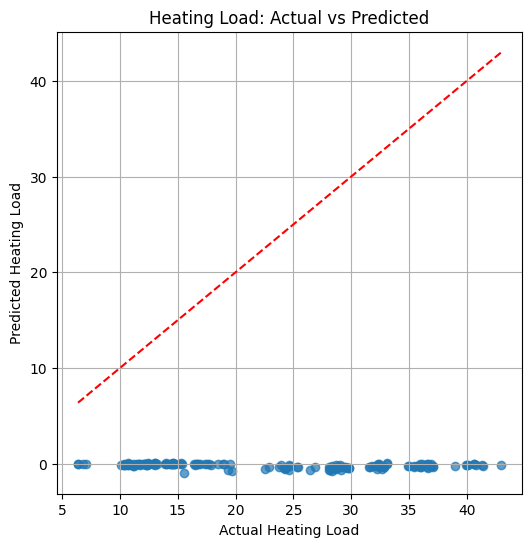

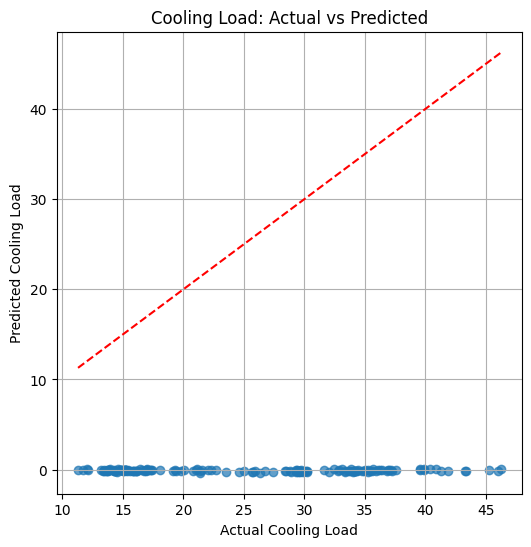

In [43]:
import matplotlib.pyplot as plt

# Separate the values
y_test_np = y_test.values
y_pred_np = y_pred

# Plot Heating Load
plt.figure(figsize=(6, 6))
plt.scatter(y_test_np[:, 0], y_pred_np[:, 0], alpha=0.7)
plt.plot([y_test_np[:, 0].min(), y_test_np[:, 0].max()],
         [y_test_np[:, 0].min(), y_test_np[:, 0].max()],
         'r--')
plt.xlabel("Actual Heating Load")
plt.ylabel("Predicted Heating Load")
plt.title("Heating Load: Actual vs Predicted")
plt.grid(True)
plt.show()

# Plot Cooling Load
plt.figure(figsize=(6, 6))
plt.scatter(y_test_np[:, 1], y_pred_np[:, 1], alpha=0.7)
plt.plot([y_test_np[:, 1].min(), y_test_np[:, 1].max()],
         [y_test_np[:, 1].min(), y_test_np[:, 1].max()],
         'r--')
plt.xlabel("Actual Cooling Load")
plt.ylabel("Predicted Cooling Load")
plt.title("Cooling Load: Actual vs Predicted")
plt.grid(True)
plt.show()


✅ 7. Make Predictions

In [10]:
# Predict on test data
y_pred = model.predict(X_test_scaled)

# Print the first 5 predictions alongside actual values
import numpy as np
for pred, actual in zip(y_pred[:5], y_test[:5]):
    print(f"Predicted: {pred[0]:.2f}, Actual: {actual:.2f}")


NameError: name 'X_test_scaled' is not defined

💾 8. Save the Model

In [11]:
model.save("energy_model.h5")  # Save in HDF5 format

# You can later load it with:

from tensorflow.keras.models import load_model

model = load_model("energy_model.h5")


ValueError: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

🧪 9. Visualize Predictions vs Actuals

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line y=x
plt.grid(True)
plt.show()
